# Data Cleaning and EDA

In [1]:
#Import libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import cv2
from skimage.io import imread

plt.style.use('fivethirtyeight')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

## Import Images and Labels

In [2]:
path = "/root/code/dsi-sg/DSIF-SG-9_private_local/capstone/VQ48 4side bright mold with labels"
# change the working directory to the path where the images are located
os.chdir(path)

# this list holds all the image filename
packages = []

# creates a ScandirIterator aliased as files
with os.scandir(path) as files:
  # loops through each file in the directory
    for file in files:
        if file.name.endswith('.png'):
          # adds only the image files to the list
            packages.append(file.name)

In [3]:
len(packages)

3892

In [4]:
print(packages[:10])

['1354.png', '746.png', '710.png', '1717.png', '3775.png', '1403.png', '1476.png', '610.png', '2814.png', '2991.png']


In [5]:
image_labels = pd.read_csv("2023_05_15_135151986_weights-improvement-epoch-0072-val_loss-3.5316e-02_0.66.pth_2. VQFN48-79_DLLLPVISURFACE4SIDEDEFECTBRIGHTMOLD-Part 1.csv")

In [6]:
image_labels.head()

,No,Batch Name,Image Result
0,1,6HUKF0L6804,Pass
1,2,6HUKF0L6804,Fail
2,3,6HUKF0L6804,Fail
3,4,6HUKF0L6804,Fail
4,5,6HUKF0L6804,Pass


In [7]:
image_labels.shape

(3892, 3)

## Data Cleaning

In [8]:
image_labels['Image Result'] = image_labels['Image Result'].map({'Pass': 0, 'Fail': 1})

In [9]:
image_labels['File Name'] = image_labels['No'].map(lambda x: str(x) + '.png')

In [10]:
df = image_labels[['File Name','Image Result']]

In [11]:
df.head()

,File Name,Image Result
0,1.png,0
1,2.png,1
2,3.png,1
3,4.png,1
4,5.png,0


In [12]:
df.to_csv('image_labels.csv', index=False)

## EDA

In order to determine the amount of preprocessing required before modeling, I investigated the images themselves. I focused on answering the following questions: 

1) Is the data unbalanced?   
2) Are the images the same size? Do they have varying aspect ratios?  
3) Are the images grayscale or do they have multiple color channels?  

To get a feel for the data, I first displayed a few sample x-rays.  

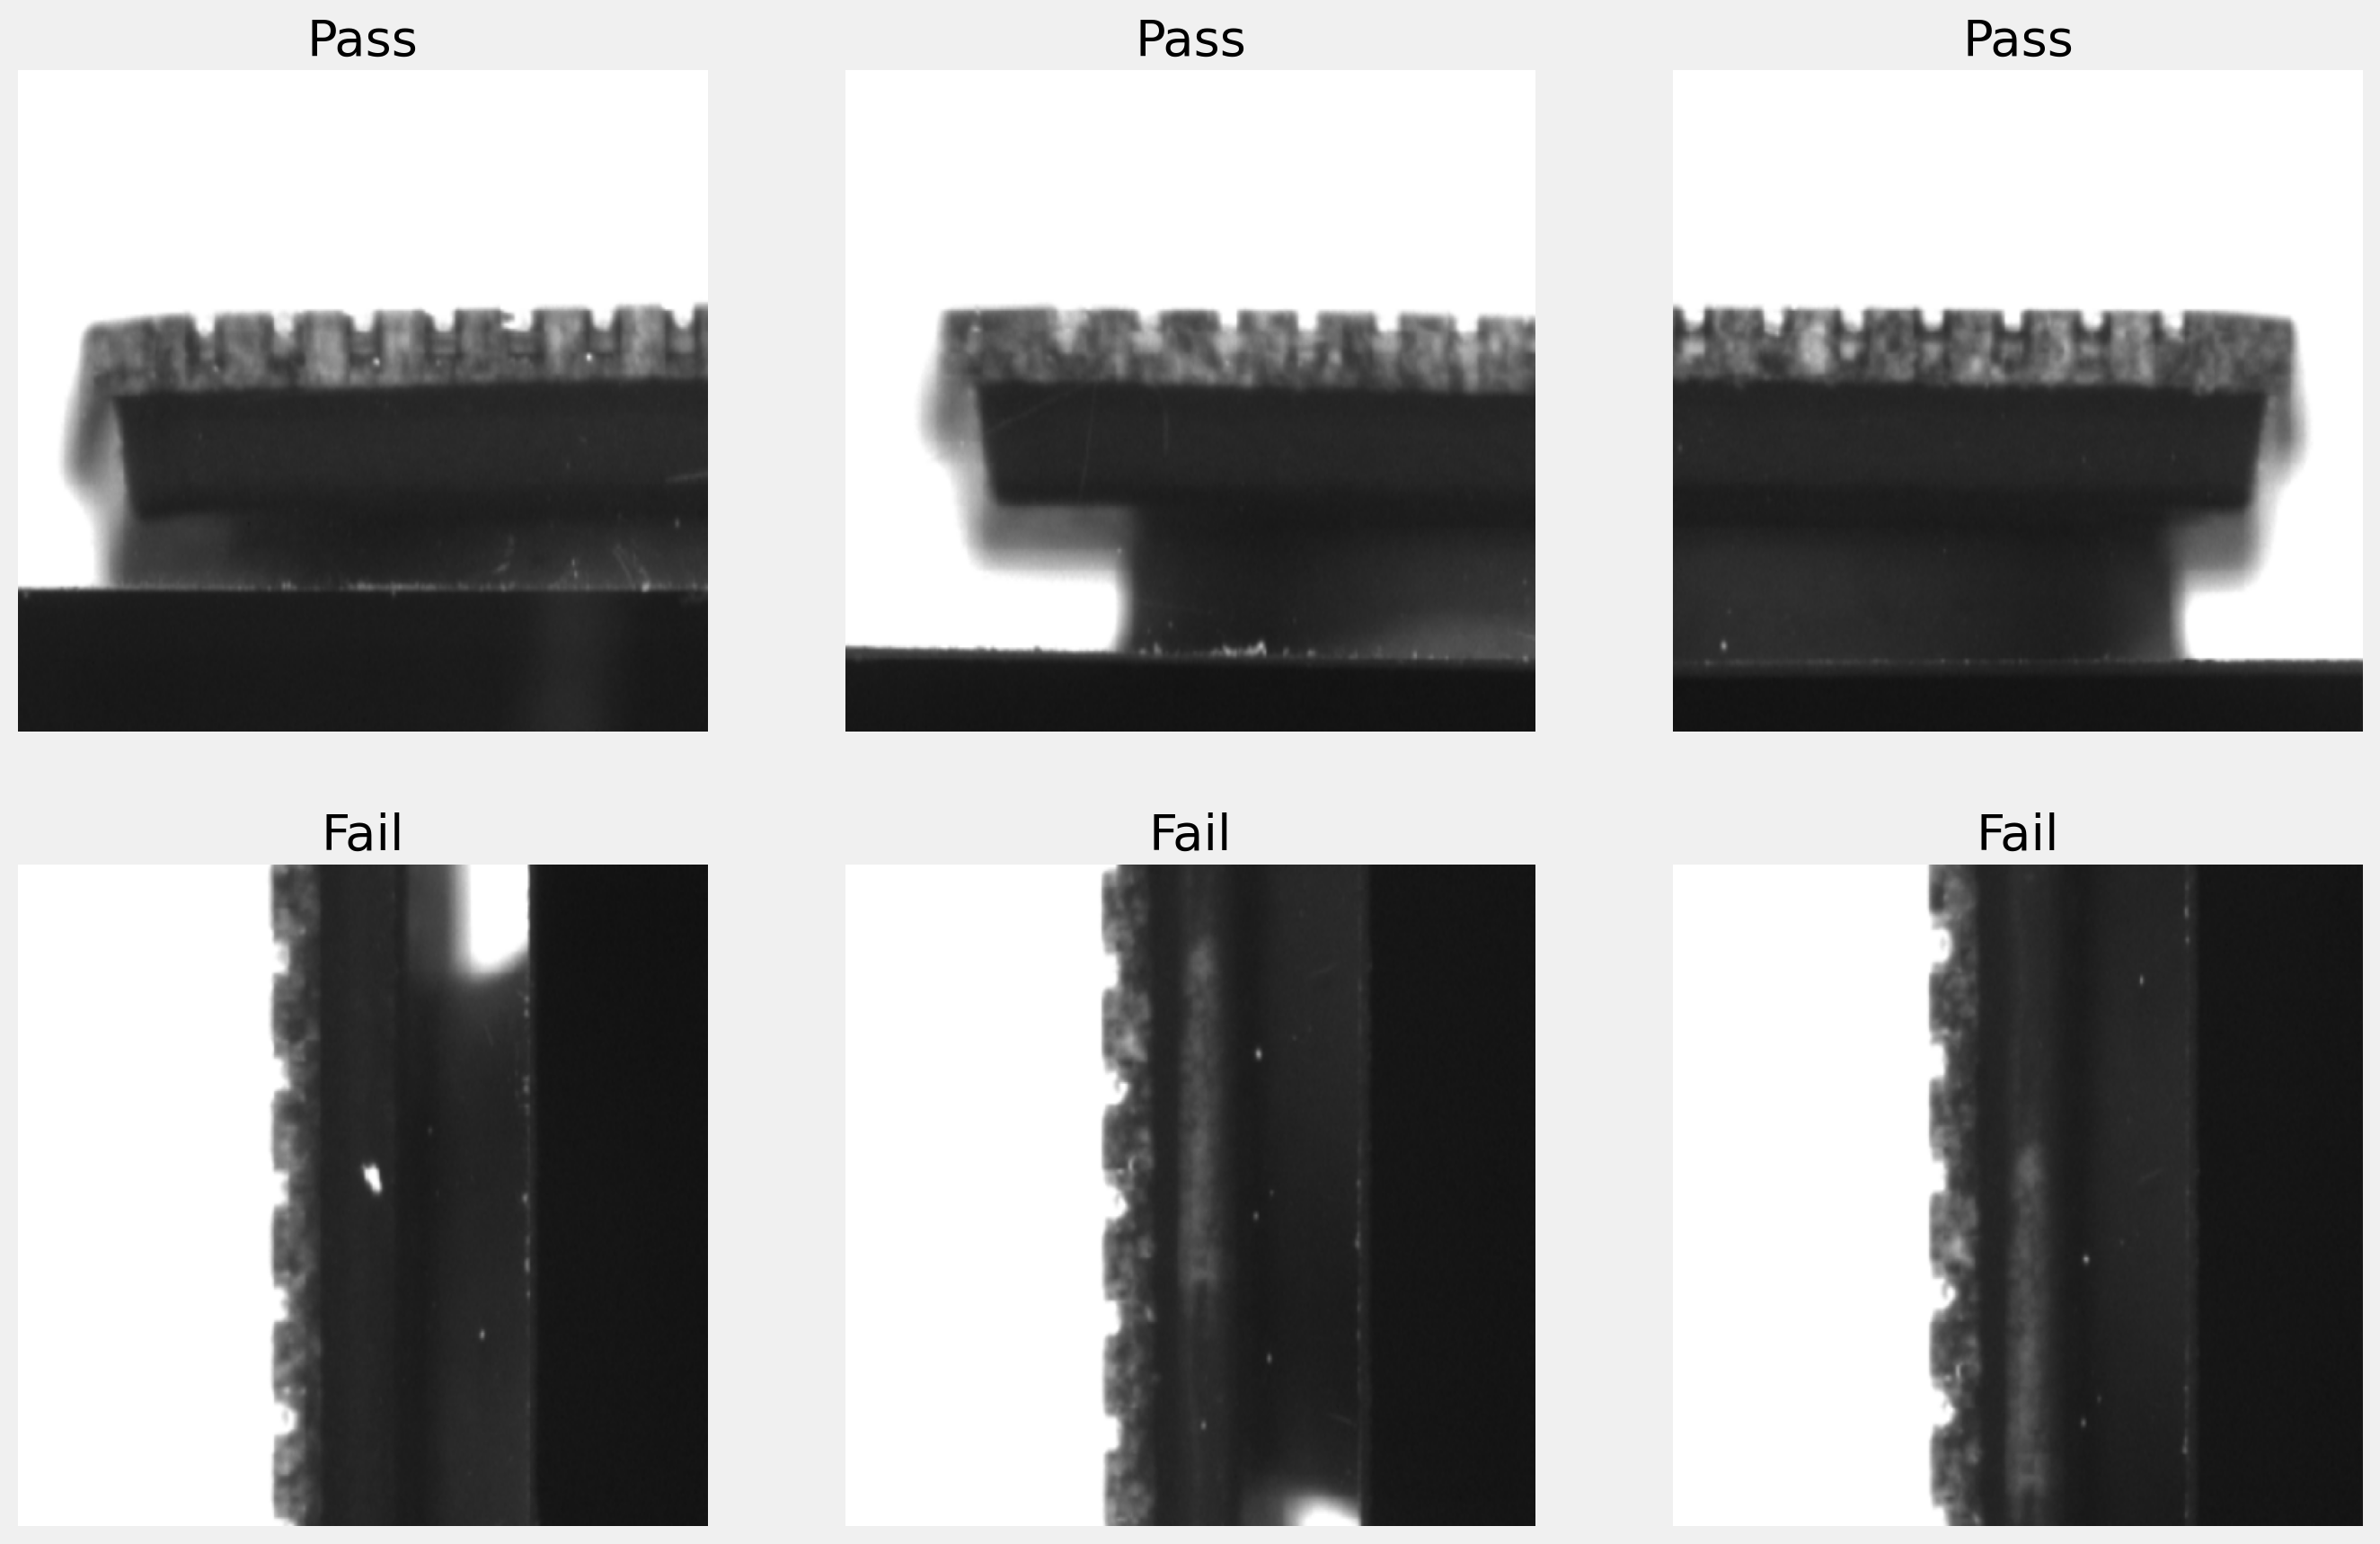

In [13]:
# Select last 3 normal and pneumonia images 
pass_packages = (image_labels[image_labels['Image Result']==0]['File Name'].tail(3)).tolist()
fail_packages = (image_labels[image_labels['Image Result']==1]['File Name'].tail(3)).tolist()

# Initiate plots 
fig, ax = plt.subplots(2,3, figsize = (15,10))

# Iterate through both sets of 3 images
for i in range(3):
    
    # Read images 
    norm = imread(pass_packages[i])
    pne = imread((fail_packages[i]))
    
    # View images
    ax[0, i].imshow(norm, cmap = 'gray')
    ax[1, i].imshow(pne, cmap = 'gray')
    
    # Labels
    ax[0, i].set_title('Pass')
    ax[1, i].set_title('Fail')
    ax[0, i].axis('off')
    ax[1, i].axis('off')
    ax[1, i].set_aspect('auto')
    ax[0, i].set_aspect('auto');

In [14]:
# Check Ratio of two images classes
image_labels['Image Result'].value_counts(normalize=True)

0    0.609455
1    0.390545
Name: Image Result, dtype: float64

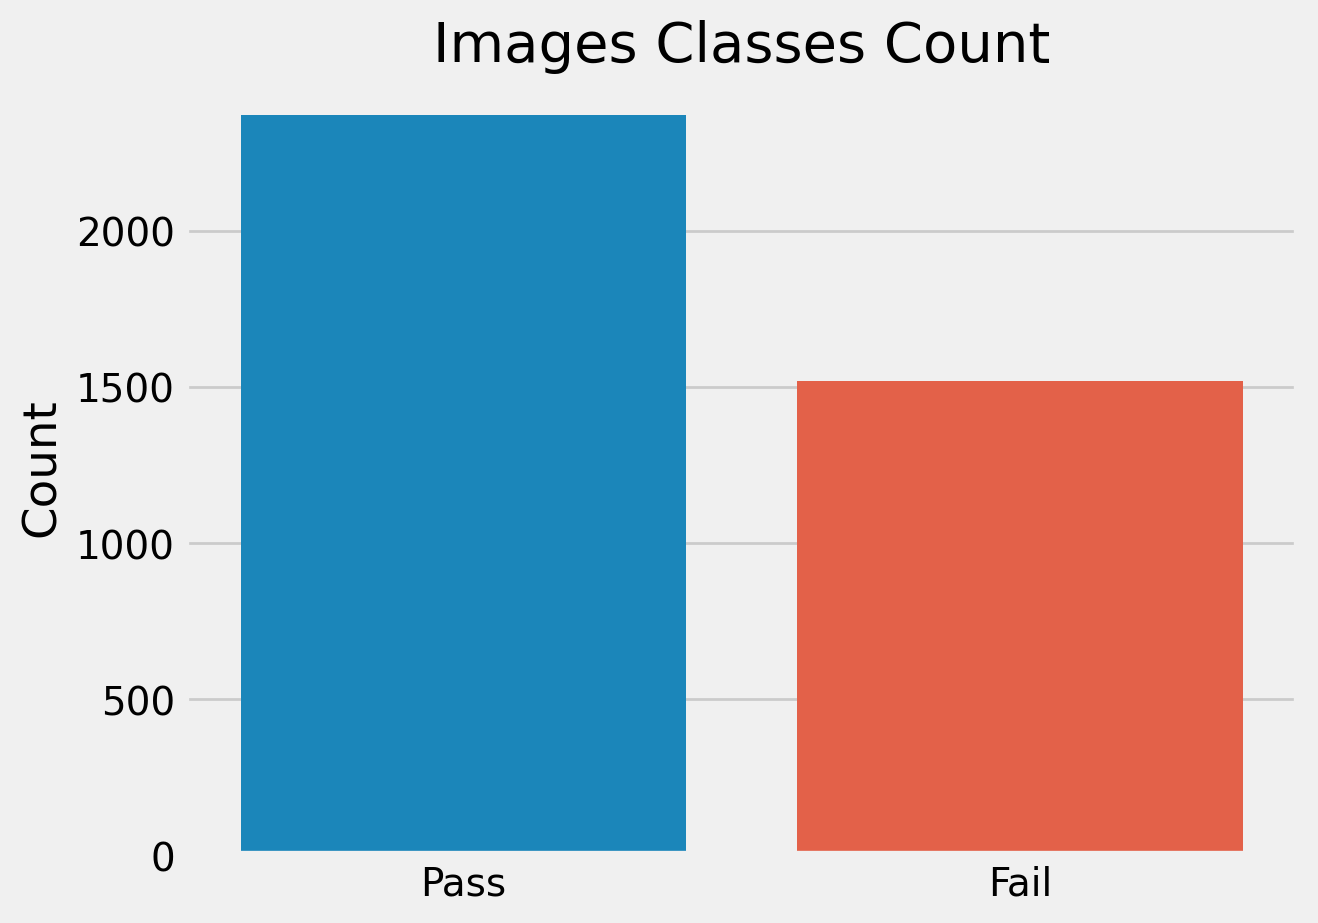

In [15]:
# Visualize class balance 
class_balance = image_labels['Image Result'].value_counts()
sns.barplot(x = ['Pass', 'Fail'], y=class_balance)
plt.ylabel('Count')
plt.title('Images Classes Count');

In [16]:
# Function to identify number of color channels, number of unique image sizes, and number of unique aspect ratios
def image_analysis(df_image_path):
    # Identify number of color channels 
    df_image = df_image_path.tolist()
    color = []
    for i in range(len(df_image)):
        read = cv2.imread(str(df_image[i]))
        color.append(read.shape[2])
    color = set(color)
    print("Number of color channels: ", color)
    
    # Identify number of unique image sizes 
    pic_shape = []
    for i in range(len(df_image)):
        read = cv2.imread(str(df_image[i]))
        pic_shape.append(read.shape[:2])
    image_sizes = set(pic_shape)
    print("Image sizes: ", image_sizes)
    
    # Identify number of unique aspect ratios: aspect ratio = rows / cols
    aspect = []
    for i in range(len(pic_shape)):
        aspect.append(pic_shape[i][0] / pic_shape[i][1])
    aspect = set(aspect)
    print("Aspect ratios: ", aspect)

In [17]:
image_analysis(image_labels['File Name'])

Number of color channels:  {3}
Image sizes:  {(370, 558), (220, 151)}
Aspect ratios:  {0.6630824372759857, 1.4569536423841059}


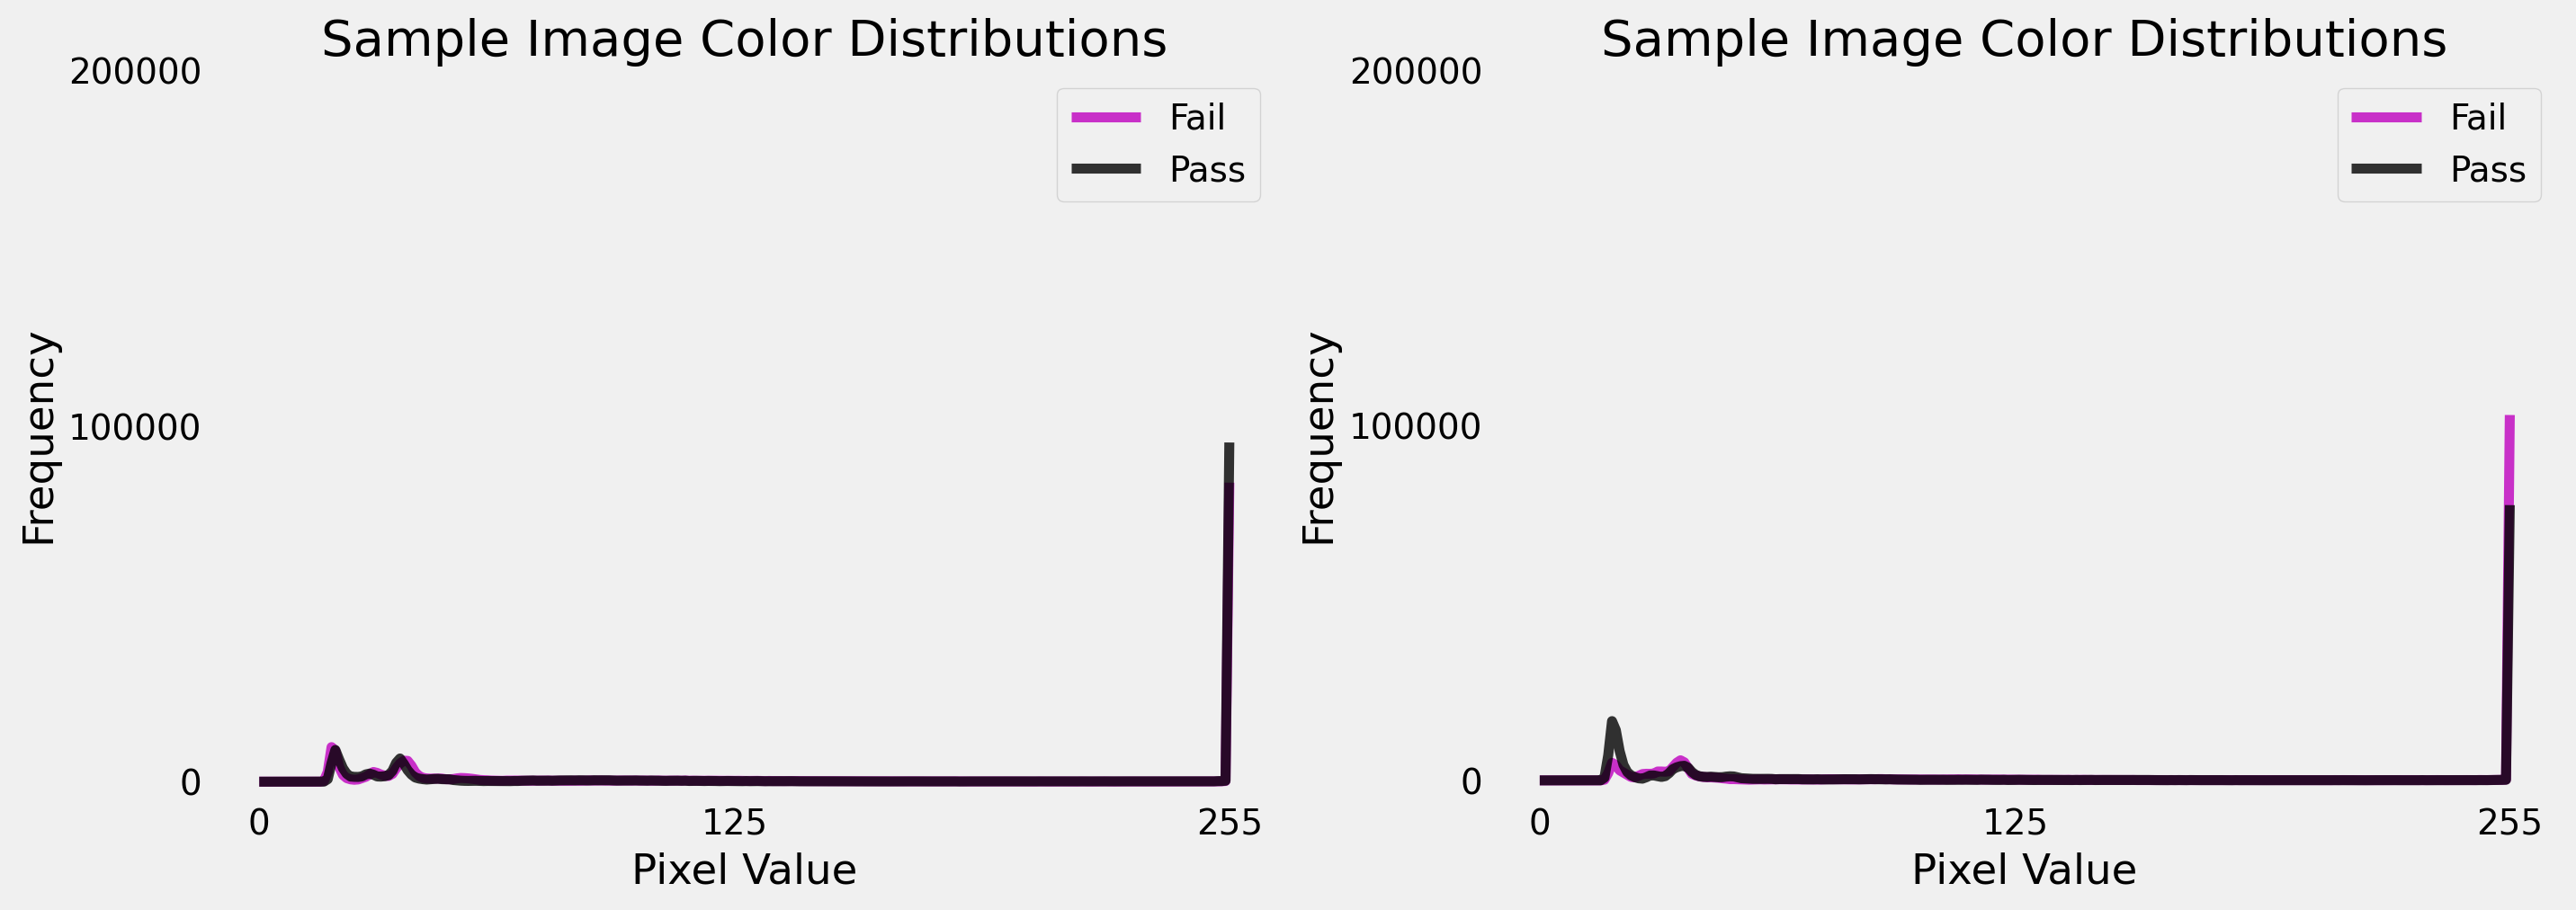

In [18]:
# Compare histograms of normal and pneumonia x-rays
fig, ax = plt.subplots(1,2,figsize = (15,5))

# Identify normal and pneumonia x-rays
pass_packages = (image_labels[image_labels['Image Result']==0]['File Name'].head(2)).tolist()
fail_packages = (image_labels[image_labels['Image Result']==1]['File Name'].head(2)).tolist()

# Read images
imgs = []
for i in range(2):
    imgs.append(cv2.imread(str(pass_packages[i])))
    imgs.append(cv2.imread(str(fail_packages[i])))

# Calculate histograms
hists = []
for i in imgs:
    hists.append(cv2.calcHist([i],[2],None,[256],[0,256]))

# Plot histograms of images
count = 0
for i in range(2):
    ax[i].plot(hists[i + count], color = 'm', label = 'Fail', alpha = 0.8)
    ax[i].plot(hists[i + 1 + count], color = 'k', label = 'Pass', alpha = 0.8)
    count += 1

# Labels
for i in range(2):
    ax[i].set_ylabel('Frequency')
    ax[i].set_xlabel('Pixel Value')
    ax[i].set_title('Sample Image Color Distributions')
    ax[i].legend(loc = 'best')
    ax[i].set_yticks([0,100000,200000])
    ax[i].set_xticks([0, 125, 255])
    ax[i].grid(False);